# Treść zadania

## Przetwarzanie asynchroniczne

- Uruchom kilkakrotnie program `node1.js`

- Wymuszanie sekwencyjnego wykonania:
  - `node1a.js`
  - `node1b.js` 

- Mechanizm obietnic
  - `node1c.js`

- Składnia `async`/`await`
  - `node1d.js`

## Zadanie 1

- `node1a.js`: Zaimplementuj funkcję `loop`, wg instrukcji w pliku `node1c.js`.
- `node1b.js`: wykorzystaj funkcję `waterfall` biblioteki `async`. 

## Zadanie 2

Proszę napisać program obliczający liczbę linii we wszystkich plikach tekstowych z danego drzewa katalogów.
Do testów proszę wykorzystać zbiór danych *Traceroute Data*. Program powinien wypisywać liczbę linii w każdym
pliku, a na końcu ich globalną sumę. 

Proszę zmierzyć czas wykonania dwóch wersji programu:

- z synchronicznym (jeden po drugim) przetwarzaniem plików,
- z asynchronicznym (jednoczesnym) przetwarzaniem plików. 

# Wstęp

**Node.js** jest to środowisko uruchomieniowe **JavaScript** o otwartym kodzie źródłowym umożliwiające uruchamianie
kodu JavaScript  na różnych platformach, między innymi: Windows, Linux, Unix, macOS. Node.js korzysta z silnika
**JavaScript V8** i pozwala na wykonywanie kodu JavaScript niezależnie od przeglądarki internetowej.

Model przetwarzania Node.js to sposób obsługi wielu współbieżnych żądań przy użyciu **pojedynczego wątku i pętli zdarzeń**.
Node.js wykorzystuje **sterowany zdarzeniami**, **nieblokujący model I/O**, który czyni go wydajnym i skalowalnym dla aplikacji 
internetowych. Oto podsumowanie modelu przetwarzania Node.js:

- Node.js działa na **pojedynczym procesie z pojedynczym wątkiem**, co oznacza, że może obsługiwać tylko jedno żądanie na raz;
- Gdy przychodzi żądanie, jest ono umieszczane w **kolejce zdarzeń**, która jest listą oczekujących zadań, które muszą zostać
  wykonane;
- Node.js wykorzystuje **pętlę zdarzeń**, która jest mechanizmem stale sprawdzającym kolejkę zdarzeń i wybierającym następne
  zadanie do wykonania;
- Pętla zdarzeń deleguje wykonywanie zadań asynchronicznych, takich jak operacje we/wy plików lub operacje sieciowe, do
  **puli wątków** w celu umożliwienia współbieżności;
- Po zakończeniu zadania asynchronicznego wywoływana jest **funkcja zwrotna (*callback*)**, która jest funkcją przekazywaną jako
  argument do innej funkcji i wykonywaną po zakończeniu zadania;
- Callback zwraca wynik zadania do pętli zdarzeń, która następnie wysyła odpowiedź z powrotem do klienta;

Model przetwarzania Node.js ma pewne **zalety** w porównaniu z tradycyjnym modelem, takie jak:

- **Jest lekki i wymaga mniej zasobów**, ponieważ nie tworzy nowego wątku dla każdego żądania;
- **Jest szybki i wydajny**, ponieważ nie blokuje głównego wątku w oczekiwaniu na zakończenie operacji wejścia/wyjścia;
- **Jest skalowalny i jest w stanie obsłużyć dużą liczbę jednoczesnych połączeń**, ponieważ wykorzystuje architekturę
  sterowaną zdarzeniami, która reaguje na zdarzenia (events), a nie na żądania (requests);

<!-- 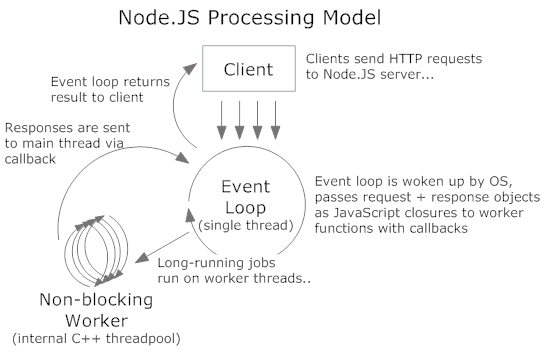 -->
$$\includegraphics[width=12cm]{attachment:image.png}$$

$$\text{Model przetwarzania Node.js}$$

# Rozwiązania

## `node1a.js`

Zgodnie z poleceniem, została utworzona funkcja `loop`, ktora powoduje wykonanie sekwencji zadań `m` razy.

Cały kod źródłowy:

```js
function printAsync(s, callback) {
    var delay = Math.floor((Math.random() * 1000) + 500);

    setTimeout(() => {
        console.log(s);

        if (callback) {
            callback();
        }
    }, delay);
}

function loop(n) {
    if (n == 0) {
        console.log('done!');
        return;
    }

    printAsync(1, () => {
        printAsync(2, () => {
            printAsync(3, () => {
                loop(n - 1);
            });
        });
    });
}

loop(3);
```

Jak widać z powyższej implementacji, została użyta rekursja z warunkiem stopu `n == 0`: po wypisaniu
ostatniej liczby w iteracji `n` funkcja `loop` zostanie wywołana z argumentem `n - 1`.

## `node1b.js`

Zgodnie z poleceniem, skorzystano z funkcji `waterfall` biblioteki `async`.

Z dokumentacji:

> Runs the tasks array of functions in series, each passing their results to the next in the array.
> However, if any of the tasks pass an error to their own callback, the next function is not executed,
> and the main callback is immediately called with the error.

Co w skrócie oznacza, że jest to sposób na uporządkowanie wykonywania funkcji, które zależą od wyników
poprzednich funkcji, bez blokowania głównego wątku.

<!-- 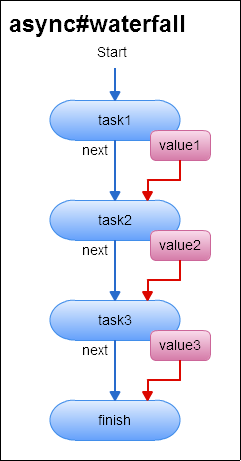 -->
$$\includegraphics[height=8cm]{attachment:async_waterfall.png}$$

$$\text{Schemat działania funkcji \texttt{async\#waterfall}}$$

Rozwiązanie wykorzystujące tylko już zdefiniowane funkcje, ale niepoprawne z punktu widzenia dokumentacji:

```js
const async = require('async');

/**
 * @param {any} s 
 * @param {() => void} callback 
 */
function printAsync(s, callback) {
    let delay = Math.floor((Math.random() * 1000) + 500);

    setTimeout(() => {
        console.log(s);

        if (callback) {
            callback();
        }
    }, delay);
}

function task1(callback) {
    printAsync("1", callback);
}

function task2(callback) {
    printAsync("2", callback);
}

function task3(callback) {
    printAsync("3", callback);
}

async.waterfall([
    task1,
    task2,
    task3
]).then((val) => {
    console.log(val);
})
```

*Wyniki zostaną omówione w odpowiednim rozdziale.*

**Rozwiązanie to nie jest zgodne z dokumentacją** ze względu na sygnaturę funkcji `callback`:

> An optional callback to run once all the functions have completed. This will be passed the results of
> the last task's callback. **Invoked with (err, [results])**.

Oczekiwana sygnatura:

```js
(e: Error, [results]) => void
```

Ale mamy:

```js
() => void
```

**Rozwiązanie zgodne z dokumentacją:**

```js
const async = require('async');

/**
 * @param {any} s 
 * @param {(e: Error, [results]) => void} callback 
 */
function callAsync(s, callback) {
    var delay = Math.floor((Math.random() * 1000) + 500);

    setTimeout(() => {
        console.log("Running", s)

        if (callback) {
            callback(null, s);
        }
    }, delay);
}

// https://caolan.github.io/async/v3/docs.html#waterfall

async.waterfall([
    callback => {
        callAsync(1, callback);
    },
    (prev, callback) => {
        console.log("Task", prev, "done");
        callAsync(2, callback)
    },
    (prev, callback) => {
        console.log("Task", prev, "done");
        callAsync(3, callback);
    }
]).then(val => {
    console.log("Task", val, "done");
    console.log("Done");
})
```

*Wyniki zostaną omówione w odpowiednim rozdziale.*

**Cała implementacja** jest następująca:

```js
const async = require('async');

/**
 * @param {any} s 
 * @param {() => void} callback 
 */
function printAsync(s, callback) {
    let delay = Math.floor((Math.random() * 1000) + 500);

    setTimeout(() => {
        console.log(s);

        if (callback) {
            callback();
        }
    }, delay);
}

function execute(tasks) {

    function iterate(index) {
        // tasks are finished
        if (index === tasks.length) {
            return;
        }

        // set the current task
        const task = tasks[index];

        /* executes the current task passing the 'iterate' function as a
         * callback, it will be called by the task itself */
        task(() => iterate(index + 1));
    }

    return iterate(0);
}

function task1(callback) {
    printAsync("1", callback);
}

function task2(callback) {
    printAsync("2", callback);
}

function task3(callback) {
    printAsync("3", callback);
}

/**
 * @param {any} s 
 * @param {(e: Error, [results]) => void} callback 
 */
function callAsync(s, callback) {
    var delay = Math.floor((Math.random() * 1000) + 500);

    setTimeout(() => {
        console.log("Running", s)

        if (callback) {
            callback(null, s);
        }
    }, delay);
}

async function main() {
    console.log("waterfall naive")

    await async.waterfall([
        task1,
        task2,
        task3
    ]).then((val) => {
        console.log(val);
    })

    console.log("waterfall")

    // https://caolan.github.io/async/v3/docs.html#waterfall

    await async.waterfall([
        callback => {
            callAsync(1, callback);
        },
        (prev, callback) => {
            console.log("Task", prev, "done");
            callAsync(2, callback)
        },
        (prev, callback) => {
            console.log("Task", prev, "done");
            callAsync(3, callback);
        }
    ]).then(val => {
        console.log("Task", val, "done");
        console.log("Done");
    })
}

// execute([task1, task2, task3]);

main()
```

## `node1c.js`

Zgodnie z poleceniem, została utworzona funkcja `loop`, ktora powoduje wykonanie sekwencji zadań `m` razy.
Analogicznie do zadania `node1a.js`, została użyta rekursja z warunkiem stopu `n == 0`: po wypisaniu
ostatniej liczby w iteracji `n` funkcja `loop` zostanie wywołana z argumentem `n - 1`.

Cały kod źródłowy:

```js
function printAsync(s, callback) {
    var delay = Math.floor((Math.random() * 1000) + 500);

    setTimeout(() => {
        console.log(s);

        if (callback) {
            callback();
        }
    }, delay);
}

function task(n) {
    return new Promise((resolve, reject) => {
        printAsync(n, () => {
            resolve(n);
        });
    });
}


// 'then' returns a new Promise, therefore we can chain another 'then'.
// In this case 'task(x)' directly returns a Promise object, however
// 'then' could also return a value in which case it would be wrapped
// in a Promise that would be automatically resolved with that value.

/*
** Zadanie:
** Napisz funkcje loop(m), ktora powoduje wykonanie powyzszej
** sekwencji zadan m razy.
**
*/

function loop(m) {
    if (m == 0)
        return;

    task(1).then((n) => {
        console.log('task', n, 'done');
        return task(2);
    }).then((n) => {
        console.log('task', n, 'done');
        return task(3);
    }).then((n) => {
        console.log('task', n, 'done');
        console.log('done!');
    }).then(() => {
        loop(m - 1);
    });
}

loop(4);
```

## `node2t.js`

Zgodnie z instrukcjami, został napisany program obliczający liczbę linii we wszystkich plikach tekstowych z
zadanego drzewa katalogów. Do testów wykorzystano zbiór danych *Traceroute Data*, który musi zostać umieszczony
w tym samym katalogu co i plik `package.json` oraz `node_modules`, tzn. struktura powinna wyglądać w sposób następujący:

```
tw-lab9
    hello_world.js
    node_modules
    package.json
    package-lock.json
    PAM08
    tasks
```

To zadanie zostało zaimplementowane **na 2 różne sposoby**:

- z synchronicznym (jeden po drugim) przetwarzaniem plików
- z asynchronicznym (jednoczesnym) przetwarzaniem plików

Implementacja znajduje się w pliku `node2.js` i wygląda w sposób następujący:

```js
const fs = require("fs");

module.exports = {
    countSync: countSync,
    countAsync: countAsync
}

/**
 * @param {string} path 
 * @param {(path: string, count: number) => void | undefined} callback 
 * @returns {Promise<void>}
 */
async function countSync(path, callback) {
    await forEachFile(path, async file => {
        const lines = await countLines(file);

        if (callback) {
            callback(file, lines)
        }
    })
}

/**
 * @param {string} path 
 * @param {(path: string, count: number) => void | undefined} callback
 * @returns {Promise<void>} 
 */
async function countAsync(path, callback) {
    return new Promise(async resolve => {
        let counter = 0
        let treeBuilt = false

        await forEachFile(path, file => {
            ++counter

            countLines(file).then(val => {
                --counter

                if (callback) {
                    callback(file, val)
                }

                if (counter == 0 && treeBuilt) {
                    resolve()
                }
            })
        })

        treeBuilt = true
    })
}

async function forEachFile(dir, callback) {
    for (let file of fs.readdirSync(dir)) {
        file = dir + "/" + file

        if (fs.statSync(file).isDirectory()) {
            await forEachFile(file, callback)
        } else {
            await callback(file)
        }
    }
}

async function countLines(filename) {
    return new Promise((resolve, reject) => {
        let count = 0

        fs.createReadStream(filename).on('data', function(chunk) {
            count += chunk.toString('utf8')
                .split(/\r\n|[\n\r\u0085\u2028\u2029]/g)
                .length - 1;
        }).on('end', function() {
            resolve(count)
        }).on('error', function (err) {
            reject(err)
        });
    })
}
```

Opis poszczególnych funkcji:

- `countSync` oblicza liczbę linii w sposób synchroniczny, tzn. przetwarza pliki jeden po drugim
- `countAsync` oblicza liczbę linii w sposób asynchroniczny, tzn. przetwarza kilka plików jednocześnie
  - W implementacji można by było skorzystać z `Promise.all`, ale to wymagałoby najpierw stworzenia tablicy
    wszystkich promise'ów, z czego postanowiono zrezygnować
- `forEachFile` wywołuje `callback` dla każdego rekursywnie znalezionego pliku
- `countLines` oblicza liczę linii w podanym pliku

Implementacja porównywania szybkości działania tych implementacji (`countSync` i `countAsync`) znajduje się
w pliku `node2t.js` i wygląda następująco:

```js
const { countSync, countAsync } = require("./node2.js")

const DATASET_DIR = "PAM08"

/**
 * 
 * @param {async () => void} func 
 * @param {number} n 
 * @returns {Promise<number>}
 */
async function benchmark(func, n) {
    let time = 0

    for (let i = 0; i < n; ++i) {
        const startTime = Date.now()
        await func()
        time += Date.now() - startTime
    }

    return time / n;
}

async function runBenchmark() {
    console.log("Starting syncMeanTime benchmark")
    const syncMeanTime = await benchmark(() => countSync(DATASET_DIR), 100)
    console.log("syncMeanTime", syncMeanTime)

    console.log("Starting asyncMeanTime benchmark")
    const asyncMeanTime = await benchmark(() => countAsync(DATASET_DIR), 100)
    console.log("asyncMeanTime", asyncMeanTime)
}

async function runDemo() {
    let syncLineCount = 0
    let asyncLineCount = 0

    console.log("Sync line counter")

    await countSync("PAM08", (filename, count) => {
        console.log(filename, count)
        syncLineCount += count
    })

    console.log("Async line counter")

    await countAsync("PAM08", (filename, count) => {
        console.log(filename, count)
        asyncLineCount += count
    })

    console.assert(syncLineCount == asyncLineCount)

    console.log("Total line count:", syncLineCount)
}

// runDemo()
runBenchmark()
```

Opis poszczególnych funkcji:

- `benchmark` mierzy średni czas wykonania funkcji `func` uruchamiając ją `n` razy
- `runBenchmark` uruchamia pomiary szybkości działania w/w implementacji
- `runDemo` wypisuje pliki wraz z liczbą linii

# Wyniki

W tym rozdziale zostały umieszczone wyniki poszczególnych programów.

Podczas testowania został użyty następujący sprzęt i oprogramowanie:

- 16 × AMD Ryzen 7 4800H with Radeon Graphics
- Fedora 38, Linux 6.5.12-200.fc38.x86_64
- Node.js v21.2.0, npm 10.2.3

In [2]:
#!/bin/bash
export PATH="/home/congard/Dev/node-v21.2.0-linux-x64/bin:$PATH"

In [4]:
#!/bin/bash
node --version
npm --version

v21.2.0
10.2.3


In [7]:
#!/bin/bash
cd "TW/labs/tw-lab9"

## `node1.js`

In [9]:
#!/bin/bash
for((i=0;i<3;i++));
do
    npm run node1
done


> tw-lab9@0.0.0 node1
> node tasks/node1.js

done!
3
1
2

> tw-lab9@0.0.0 node1
> node tasks/node1.js

done!
1
3
2

> tw-lab9@0.0.0 node1
> node tasks/node1.js

done!
2
3
1


Jak widać, na wejściu otrzymaliśmy liczby wypisane za każdym uruchomieniem w różnej kolejności.
To wynika z tego, że wypisywaliśmy je asynchronicznie najpierw czekając przez wylosowany okres czasu.

## `node1a.js`

In [10]:
#!/bin/bash
npm run node1a


> tw-lab9@0.0.0 node1a
> node tasks/node1a.js

1
2
3
1
2
3
1
2
3
done!


Tym razem widać, że wszystkie liczby zostały wypisane w poprawnej kolejności 3 razy, a więc
funkcja `loop` działa poprawnie.

## `node1b.js`

In [11]:
#!/bin/bash
npm run node1b


> tw-lab9@0.0.0 node1b
> node tasks/node1b.js

waterfall naive
1
2
3
undefined
waterfall
Running 1
Task 1 done
Running 2
Task 2 done
Running 3
Task 3 done
Done


Widać, że w przypadku implementacji niezgodnej z dokumentacją na końcu jako wynik funkcji
`async#waterfall` wypisuje się `undefined`. W przypadku poprawnej implementacji, tego nie
obserwujemy - wszystko działa zgodnie z oczekiwaniami i dokumentacja.

## `node1c.js`

In [12]:
#!/bin/bash
npm run node1c


> tw-lab9@0.0.0 node1c
> node tasks/node1c.js

1
task 1 done
2
task 2 done
3
task 3 done
done!
1
task 1 done
2
task 2 done
3
task 3 done
done!
1
task 1 done
2
task 2 done
3
task 3 done
done!
1
task 1 done
2
task 2 done
3
task 3 done
done!


Wszystkie liczby zostały wypisane w poprawnej kolejności 4 razy, a więc funkcja `loop` działa poprawnie.

## `node1d.js`

In [13]:
#!/bin/bash
npm run node1d


> tw-lab9@0.0.0 node1d
> node tasks/node1d.js

1
2
3
1
2
3
1
2
3
1
2
3


Wszystkie liczby zostały wypisane w poprawnej kolejności 4 razy, a więc funkcja `loop` działa poprawnie.

## `node2t.js`

In [14]:
#!/bin/bash
npm run node2t


> tw-lab9@0.0.0 node2t
> node tasks/node2t.js

Starting syncMeanTime benchmark
syncMeanTime 301.22
Starting asyncMeanTime benchmark
asyncMeanTime 128.19


Z otrzymanych pomiarów wynika, że asynchroniczne przetwarzanie plików jest ponad 2 razy szybsze
w porównaniu z synchronicznym.

# Wnioski

- **Node.js jest środowiskiem uruchomieniowym** JavaScript, które umożliwia tworzenie aplikacji w tym języku
  działających poza przeglądarką;

- **Node.js wykorzystuje silnik JavaScript V8**, który jest szybki i optymalizowany dla nowoczesnych standardów webowych;

- **Node.js obsługuje wiele współbieżnych żądań** przy użyciu pojedynczego wątku i pętli zdarzeń, która deleguje zadania
  asynchroniczne do puli wątków;

- **Node.js jest lekki, wydajny i skalowalny**, ponieważ nie blokuje głównego wątku i reaguje na zdarzenia, a nie na żądania;

- **`await`/`async`**: jest to sposób na pracę z obietnicami (promises) w asynchronicznych funkcjach. Jest to tzw. syntactic
  sugar, czyli uproszczenie składni, które sprawia, że kod z obietnicami jest łatwiejszy do czytania i pisania. Dzięki temu
  kod asynchroniczny wygląda bardziej jak synchroniczny/proceduralny. Funkcje `async` zawsze zwracają `Promise`, nawet jeśli
  operacja, którą wykonują, jest synchroniczna;

- **`Promise`**: jest to obiekt reprezentujący końcowy wynik operacji asynchronicznej. Obietnica może znajdować się
  *w jednym z trzech stanów*: oczekującym (pending), spełnionym (fulfilled) lub odrzuconym (rejected). Główną zaletą `Promise`
  jest unikanie tzw. "callback hell", czyli zagnieżdżania wielu wywołań zwrotnych (callbacks), co może prowadzić do nieczytelnego kodu;

- **Metoda `then`** jest używana do zarejestrowania callbacków, które będą wywoływane, gdy `Promise` zostanie spełniony lub
  odrzucony. Pierwszy argument to funkcja, która zostanie wywołana, gdy `Promise` zostanie spełniony (`resolve`), a drugi
  argument to funkcja, która zostanie wywołana, gdy `Promise` zostanie odrzucony (`reject`);

- **`async.waterfall`**: jest to funkcja z biblioteki *`async.js`*, która pozwala na wykonanie serii asynchronicznych funkcji
  jeden po drugim. Każda kolejna funkcja otrzymuje wyniki poprzedniej funkcji. Jeśli któraś z funkcji przekaże błąd do swojego
  callbacku, nie zostaną wykonane żadne kolejne funkcje, a główny callback zostanie natychmiast wywołany z błędem;

- Asynchroniczne (jednoczesne) przetwarzanie plików okazało się ponad 2 razy szybsze w porównaniu z synchronicznym
  (jeden po drugim);

# Bibliografia

1. Materiały do laboratorium, dr inż. Włodzimierz Funika:\
   [https://home.agh.edu.pl/~funika/tw/lab-js/](https://home.agh.edu.pl/~funika/tw/lab-js/)

2. Zbiór danych *Traceroute Data*:\
   [http://home.agh.edu.pl/~funika/tw/lab-js/pam08.zip](http://home.agh.edu.pl/~funika/tw/lab-js/pam08.zip)

3. Node.js, Wikipedia:\
   [https://en.wikipedia.org/wiki/Node.js](https://en.wikipedia.org/wiki/Node.js)

4. Exploring Async.js – async.waterfall and async.series, Pentacode:\
   [https://www.penta-code.com/02-exploring-async-js-async-waterfall-and-async-series/](https://www.penta-code.com/02-exploring-async-js-async-waterfall-and-async-series/)

5. `async`, Async Docs:\
   [https://caolan.github.io/async/v3/docs.html](https://caolan.github.io/async/v3/docs.html)

6. `fs`, Node.js v21 Docs:\
   [https://nodejs.org/docs/latest-v21.x/api/fs.html](https://nodejs.org/docs/latest-v21.x/api/fs.html)

7. How do you get a list of the names of all files present in a directory in Node.js?, Stackoverflow Question:\
   [https://stackoverflow.com/q/2727167](https://stackoverflow.com/q/2727167)

8. Coordinating parallel execution in node.js, Stackoverflow Question:\
   [https://stackoverflow.com/q/4631774](https://stackoverflow.com/q/4631774)

9. `Promise.all`, MDN Web Docs:\
   [https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Promise/all](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Promise/all)

10. Difference between promise and async await in Node.js, GeeksForGeeks:\
    [https://www.geeksforgeeks.org/difference-between-promise-and-async-await-in-node-js/](https://www.geeksforgeeks.org/difference-between-promise-and-async-await-in-node-js/)

11. async/await vs. Promises - Which should I use?, Delving Developer:\
    [https://delvingdeveloper.com/posts/async-await-vs-promises](https://delvingdeveloper.com/posts/async-await-vs-promises)

12. How to Use JavaScript Promises – Callbacks, Async/Await, and Promise Methods Explained, Yogesh Chavan, freeCodeCamp:\
    [https://www.freecodecamp.org/news/javascript-promises-async-await-and-promise-methods/](https://www.freecodecamp.org/news/javascript-promises-async-await-and-promise-methods/)